In [0]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn import metrics

In [8]:
df_consum=pd.read_csv("/content/consumos.csv",sep=';')
df_fugas=pd.read_csv("/content/FUGAS.csv",sep=';')
df_consum=df_consum.dropna()
df_consum=df_consum.drop_duplicates()
df_consum.head()

,CONTRATO,1q/2011,2q/2011,3q/2011,4q/2011,1q/2012,2q/2012,3q/2012,4q/2012,1q/2013,2q/2013,3q/2013,4q/2013,1q/2014,2q/2014,3q/2014,4q/2014,1q/2015,2q/2015,3q/2015,4q/2015,1q/2016,2q/2016,3q/2016,4q/2016,1q/2017,2q/2017,3q/2017,4q/2017,1q/2018,2q/2018,3q/2018,4q/2018,1q/2019,2q/2019,3q/2019,4q/2019
58,CTO_TO_024012,3.0,7.0,7.0,2.0,5.0,6.0,4.0,2.0,4.0,5.0,4.0,5.0,9.0,6.0,7.0,8.0,10.0,10.0,10.0,24.0,27.0,15.0,16.0,17.0,15.0,12.0,8.0,8.0,9.0,8.0,8.0,7.0,8.0,8.0,8.0,9.0
60,CTO_TO_024013,14.0,16.0,14.0,10.0,13.0,19.0,18.0,16.0,21.0,24.0,19.0,18.0,19.0,20.0,21.0,16.0,18.0,18.0,18.0,18.0,23.0,19.0,19.0,16.0,15.0,18.0,16.0,15.0,19.0,19.0,15.0,15.0,15.0,17.0,13.0,11.0
61,CTO_TO_024596,23.0,21.0,82.0,34.0,28.0,20.0,39.0,36.0,16.0,18.0,40.0,39.0,27.0,29.0,51.0,41.0,28.0,21.0,46.0,40.0,26.0,26.0,43.0,60.0,19.0,22.0,44.0,27.0,28.0,24.0,87.0,27.0,23.0,21.0,84.0,27.0
62,CTO_TO_026480,4.0,3.0,4.0,4.0,2.0,4.0,4.0,3.0,4.0,1.0,3.0,3.0,4.0,3.0,4.0,2.0,5.0,3.0,4.0,4.0,3.0,4.0,4.0,2.0,3.0,3.0,4.0,2.0,4.0,2.0,3.0,9.0,2.0,3.0,3.0,3.0
64,CTO_TO_002150,18.0,22.0,20.0,20.0,23.0,19.0,19.0,15.0,20.0,19.0,15.0,21.0,33.0,19.0,17.0,16.0,24.0,19.0,15.0,14.0,19.0,18.0,16.0,14.0,20.0,19.0,17.0,13.0,16.0,11.0,10.0,8.0,13.0,12.0,11.0,12.0


In [0]:
def getDataset(df_consum,df_fugas):

  #We get all contracts that showed a leak at some point
  df_consum_fuga=pd.merge(df_consum,df_fugas,on='CONTRATO')
  df_copy=df_consum_fuga

  #We need the consume of at least 4 quarters (a year) before a leak happended
  for i, row in df_consum_fuga.iterrows():
    if row['Fecha_FI']=='1q/2011' or row['Fecha_FI']=='2q/2011' or row['Fecha_FI']=='3q/2011' or row['Fecha_FI']=='4q/2011' or row['Fecha_FI']=='1q/2012':
      df_copy=df_copy.drop(i)

  #We get our dataset for "fugas"
  print('Obtaining leaks dataset....')
  df_ds_fugas=pd.DataFrame(columns=['x1','x2','x3','x4','y'])
  for i, row in df_copy.iterrows():
    colName=row['Fecha_FI']
    col_index=df_copy.columns.get_loc(colName)
    df_ds_fugas=df_ds_fugas.append({'x1': row[col_index-4],'x2': row[col_index-3],'x3': row[col_index-2],'x4': row[col_index-1],'y':'F'}, ignore_index=True)
 
  #We get our dataset for "No fugas"
  print('Obtaining NoLeaks dataset...')
  cto_sin=list(set(df_consum['CONTRATO'])-set(df_consum_fuga['CONTRATO']))
  df_ds_nofuga=pd.DataFrame(columns=['x1','x2','x3','x4','y'])
  for i, row in df_consum.iterrows():
    if row['CONTRATO'] in cto_sin:
      df_ds_nofuga=df_ds_nofuga.append({'x1': row[20],'x2': row[21],'x3': row[22],'x4': row[23],'y':'NF'}, ignore_index=True)
  
  #We mix both df with and without leaks
  print('Generating final dataset...')
  balanced=round((len(df_ds_fugas)/len(df_ds_nofuga)),2)#We want a balanced dataset
  df_dataset=pd.concat([df_ds_fugas,df_ds_nofuga.sample(frac = balanced)])
  return df_dataset


In [10]:
df=getDataset(df_consum,df_fugas)

Obtaining leaks dataset....
Obtaining NoLeaks dataset...
Generating final dataset...


In [0]:
def getScaledDF(df):
  scaler = StandardScaler()
  #We want to scale our numeric data
  df_train=df.iloc[:,:-1]
  res=pd.DataFrame(scaler.fit_transform(df_train),columns=df_train.columns)
  res['y']=list(df['y'])
  return res

In [0]:
df_scaled=getScaledDF(df)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df_scaled.iloc[:,:-1], df_scaled['y'], test_size=0.2)

In [0]:
def getBestModel(X_train,y_train):

  #Parameters for our different models
  param_grid_knn = {'n_neighbors': [1,2,3,4,5]}
  param_grid_rf = {'n_estimators': list(range(10)),'max_features': ['auto', 'sqrt'],'max_depth': list(range(10))}
  param_grid_svm = {'kernel': ['linear','rbf','poly']}
  ls_params=[param_grid_knn,param_grid_rf,param_grid_svm]

  #Models we are going to try
  models=[knn(),RandomForestClassifier(),SVC()]
  res_score=list()
  res_param=list()
  chosen_model=None
  chosen_param=None

  #We apply gridSearchCV to every model with different parameters and CV=10 folds
  for i in range(len(models)):
    print(i)
    search = GridSearchCV(models[i], ls_params[i], cv=10,n_jobs=-1)
    gs_results=search.fit(X_train, y_train)
    res_score.append(gs_results.best_score_)
    res_param.append(gs_results.best_params_)

  #Time to return the best model with the best parameters :)
  best=res_score.index(max(res_score))
  chosen_model=models[best]
  chosen_param=res_param[best]
  return chosen_model, chosen_param, max(res_score)

In [15]:
a,b,c=getBestModel(X_train,y_train)
print(a)
print(b)
print(c)

0
1
2
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
{'max_depth': 9, 'max_features': 'sqrt', 'n_estimators': 9}
0.7950191570881225


In [19]:
#With max_depth=8 and max_features='auto',n_estimators=8 we get 80% accuracy
clf=RandomForestClassifier(max_depth=8, max_features='auto',n_estimators=8)
clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=8,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Accuracy: 0.7904
F1 score: 0.7903


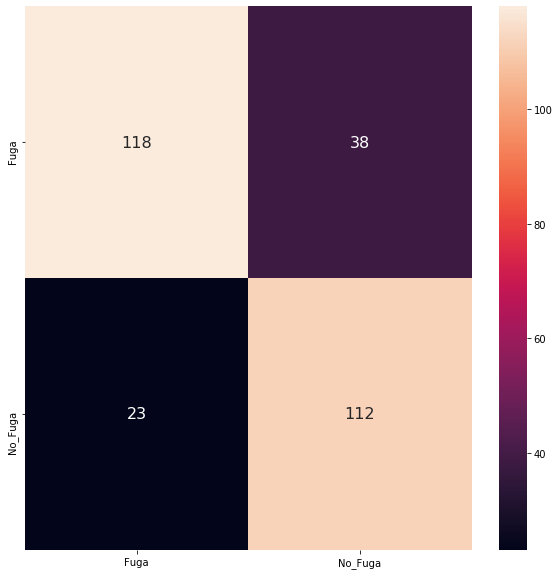

In [20]:
#Time to predict our test dataset
y_pred=clf.predict(X_test)

#We show results in a confusion matrix
cm=confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm,index=['Fuga','No_Fuga'],columns = ['Fuga','No_Fuga'])
plt.figure(figsize = (10,10))
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt='g')

#Which are out metrics?
print('Accuracy: '+str(round(metrics.accuracy_score(y_test, y_pred),4)))
print('F1 score: '+str(round(metrics.f1_score(y_test, y_pred, average='macro'),4)))